In [9]:
import os
import cv2
import glob
import h5py
import shutil
import keras
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as augment
import tensorflow as tf
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path

from skimage.io import imread
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D,GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,EarlyStopping,TensorBoard,ReduceLROnPlateau,CSVLogger,LearningRateScheduler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
color = sns.color_palette()
%matplotlib inline

In [10]:
train = '../input/chest-xray-pneumonia/chest_xray/train/'
val = '../input/chest-xray-pneumonia/chest_xray/val/'
test = '../input/chest-xray-pneumonia/chest_xray/test/'

normal_data_dir = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
pneumonia_data_dir = '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'


In [11]:
SIZE = 128
BATCH = 16

augs = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_augs = ImageDataGenerator(rescale=1./255)

train_generator = augs.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_generator = val_augs.flow_from_directory(
    test,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

val_generator = val_augs.flow_from_directory(
    val,
    target_size=(224, 224),
    batch_size=16,
    shuffle=False,
    class_mode='binary'
)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
!pip install efficientnet

In [13]:
import efficientnet.keras as efn
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

# Callbacks
## Keep the best model
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)
# Model
## Define the base model with EfficientNet weights
model = efn.EfficientNetB4(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (SIZE, SIZE, 3))

## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])
model_history = model.fit(train_generator,
                            validation_data=val_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=val_generator.n/BATCH,
                            epochs=20,
                            verbose=1,
                            callbacks=[mc, rlr])

Epoch 1/20
326/326 [==============================] - 182s 489ms/step - loss: 0.2529 - accuracy: 0.8974 - recall_1: 0.9230 - precision_1: 0.9382 - val_loss: 0.1428 - val_accuracy: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 2/20
326/326 [==============================] - 155s 476ms/step - loss: 0.1406 - accuracy: 0.9461 - recall_1: 0.9586 - precision_1: 0.9700 - val_loss: 0.4478 - val_accuracy: 0.7500 - val_recall_1: 1.0000 - val_precision_1: 0.6667
Epoch 3/20
326/326 [==============================] - 156s 477ms/step - loss: 0.0725 - accuracy: 0.9719 - recall_1: 0.9811 - precision_1: 0.9815 - val_loss: 0.1950 - val_accuracy: 0.8750 - val_recall_1: 0.7500 - val_precision_1: 1.0000
Epoch 4/20
326/326 [==============================] - 152s 467ms/step - loss: 0.0789 - accuracy: 0.9699 - recall_1: 0.9792 - precision_1: 0.9802 - val_loss: 0.3329 - val_accuracy: 0.8125 - val_recall_1: 1.0000 - val_precision_1: 0.7273

Epoch 00004: ReduceLROnPlateau reducing learning rate t

In [14]:
model.load_weights("model.hdf5")

<Figure size 432x288 with 0 Axes>

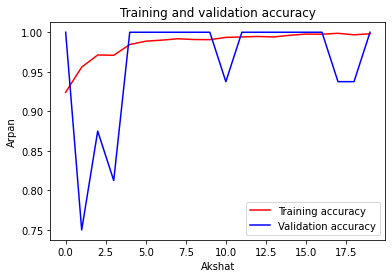

<Figure size 432x288 with 0 Axes>

In [15]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Akshat')
plt.ylabel('Arpan')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


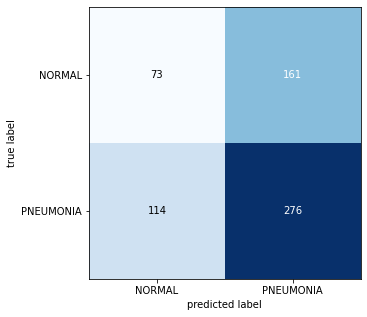

In [16]:
preds = model.predict_generator(generator=test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt_labels = ['NORMAL','PNEUMONIA']
ax.set_xticklabels([''] + plt_labels)
ax.set_yticklabels([''] + plt_labels)
plt.show()